# Import Library

In [97]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot  as plt
from datetime import datetime

# Normality test
from scipy.stats import chi2_contingency
from scipy.stats import shapiro
from scipy.stats import normaltest
import scipy.stats as st

#Encoding 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

#model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import lightgbm as lgb
from lightgbm import LGBMClassifier

#score_metrics & cross validation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, KFold

# Load Data

In [98]:
df = pd.read_csv('Clicked Ads Dataset.csv')

In [99]:
df.sample(5)

,Unnamed: 0,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Timestamp,Clicked on Ad,city,province,category
962,962,70.09,21,383081090.0,211.17,Perempuan,1/22/2016 12:58,No,Jakarta Selatan,Daerah Khusus Ibukota Jakarta,Otomotif
741,741,70.90,28,502092570.0,190.95,Perempuan,6/17/2016 23:19,No,Bandung,Jawa Barat,Health
319,319,62.06,44,309219750.0,105.00,Perempuan,4/12/2016 14:01,Yes,Makassar,Sulawesi Selatan,Health
869,869,82.41,36,461179670.0,222.08,Perempuan,4/12/2016 4:22,No,Jakarta Utara,Daerah Khusus Ibukota Jakarta,Fashion
464,464,88.04,45,438128880.0,191.17,Laki-Laki,3/7/2016 20:02,No,Jakarta Timur,Daerah Khusus Ibukota Jakarta,Health


In [100]:
df = df.rename(columns={'Male':'Gender'})

In [101]:
missing_value = df.isnull().sum().reset_index()
missing_value.columns = ['Kolom', 'Jumlah Missing Value']
missing_value['Persentase Missing Value'] = missing_value['Jumlah Missing Value']/df.shape[0]*100
fitur = missing_value['Kolom'].unique().tolist()
list=[]
for i in range(0, len(fitur)):
    tipe = missing_value['Kolom'][i]
    tipe_data = df[tipe].dtypes
    list.append(tipe_data)
list
missing_value['Tipe Data'] = list

In [102]:
missing_value = missing_value.sort_values(by='Persentase Missing Value', ascending=False)
missing_value

,Kolom,Jumlah Missing Value,Persentase Missing Value,Tipe Data
1,Daily Time Spent on Site,13,1.3,float64
3,Area Income,13,1.3,float64
4,Daily Internet Usage,11,1.1,float64
5,Gender,3,0.3,object
0,Unnamed: 0,0,0.0,int64
2,Age,0,0.0,int64
6,Timestamp,0,0.0,object
7,Clicked on Ad,0,0.0,object
8,city,0,0.0,object
9,province,0,0.0,object


In [103]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')

In [104]:
print(df['Timestamp'].max())
print(df['Timestamp'].min())

2016-07-24 00:22:00
2016-01-01 02:52:00


In [105]:
df['Day'] = df['Timestamp'].dt.day
df['Month'] = df['Timestamp'].dt.month_name()
df['Day_Name'] = df['Timestamp'].dt.day_name()

In [106]:
df = df.drop('Unnamed: 0', axis=1)

In [107]:
df.sample()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Gender,Timestamp,Clicked on Ad,city,province,category,Day,Month,Day_Name
317,73.38,25,371412370.0,236.19,Laki-Laki,2016-04-21 09:30:00,No,Jakarta Barat,Daerah Khusus Ibukota Jakarta,Travel,21,April,Thursday


In [108]:
df.duplicated().sum()

0

In [109]:
# Ignore warning
import warnings
warnings.filterwarnings("ignore")

In [110]:
categoric = df.loc[:, df.dtypes==np.object]
numeric = df.loc[:, df.dtypes!=np.object]
numeric = numeric.drop('Timestamp', axis=1)
timestamp = df[['Timestamp']]

# Exploratory Data Analysis

In [111]:
numeric.describe()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Day
count,987.000000,1000.000000,9.870000e+02,989.000000,1000.000000
mean,64.929524,36.009000,3.848647e+08,179.863620,15.484000
std,15.844699,8.785562,9.407999e+07,43.870142,8.734073
min,32.600000,19.000000,9.797550e+07,104.780000,1.000000
25%,51.270000,29.000000,3.286330e+08,138.710000,8.000000
50%,68.110000,35.000000,3.990683e+08,182.650000,15.000000
75%,78.460000,42.000000,4.583554e+08,218.790000,23.000000
max,91.430000,61.000000,5.563936e+08,267.010000,31.000000


In [112]:
categoric.describe()

,Gender,Clicked on Ad,city,province,category,Month,Day_Name
count,997,1000,1000,1000,1000,1000,1000
unique,2,2,30,16,10,7,7
top,Perempuan,No,Surabaya,Daerah Khusus Ibukota Jakarta,Otomotif,February,Sunday
freq,518,500,64,253,112,160,159


In [113]:
timestamp.describe()

,Timestamp
count,1000
unique,997
top,2016-05-26 15:40:00
freq,2
first,2016-01-01 02:52:00
last,2016-07-24 00:22:00


## Handling Missing Value

In [114]:
df['Daily Time Spent on Site'].fillna(df['Daily Time Spent on Site'].quantile(0.50), inplace=True)
df['Area Income'].fillna(df['Area Income'].quantile(0.50), inplace=True)
df['Daily Internet Usage'].fillna(df['Daily Internet Usage'].quantile(0.50), inplace=True)
df['Gender'].fillna('Perempuan', inplace=True)

In [115]:
df.isnull().sum()

Daily Time Spent on Site    0
Age                         0
Area Income                 0
Daily Internet Usage        0
Gender                      0
Timestamp                   0
Clicked on Ad               0
city                        0
province                    0
category                    0
Day                         0
Month                       0
Day_Name                    0
dtype: int64

## Univariate Analysis

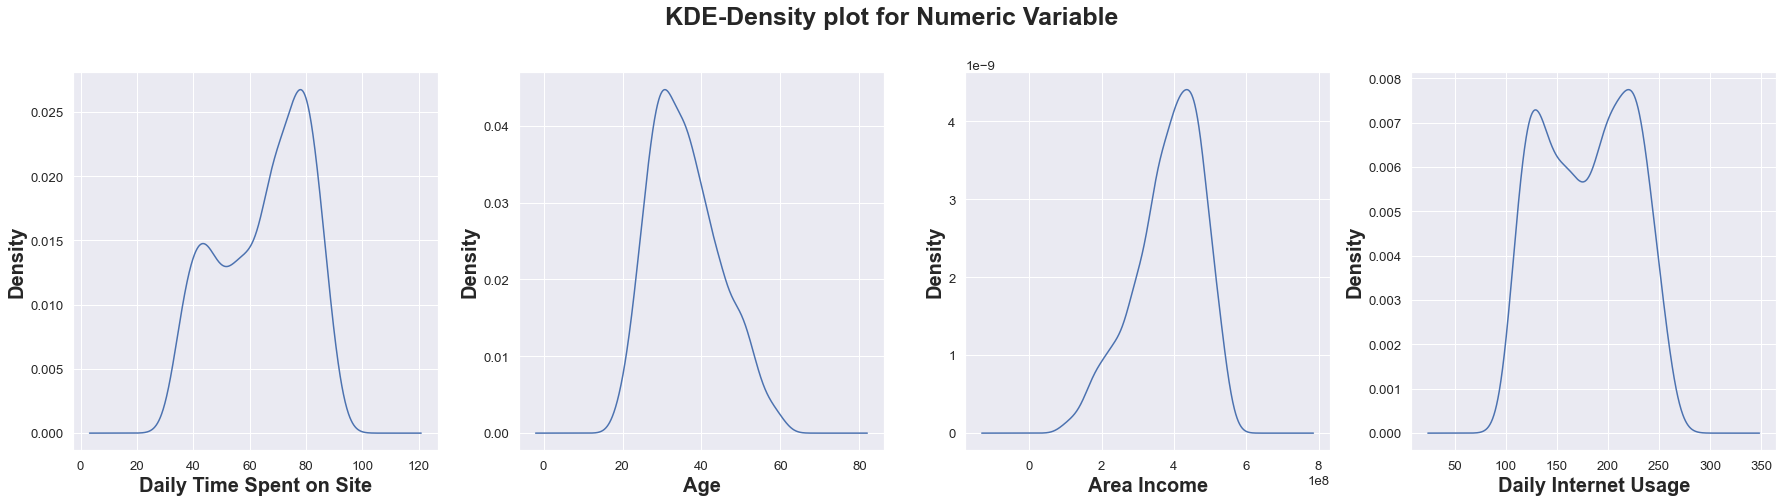

In [116]:
fitur = ['Daily Time Spent on Site','Age', 'Area Income', 'Daily Internet Usage']

for i in range(0, len(fitur)):
    plt.rcParams["figure.figsize"] = (25,7)
    sns.set(font_scale=1.2)
    plt.subplot(1,4,i+1)
    df[fitur[i]].plot.kde()
    plt.xlabel(fitur[i],weight='bold', fontsize=20)
    plt.ylabel('Density', weight='bold', fontsize=20)
    plt.suptitle('KDE-Density plot for Numeric Variable', weight='bold', fontsize=25, y=1)
    plt.tight_layout()

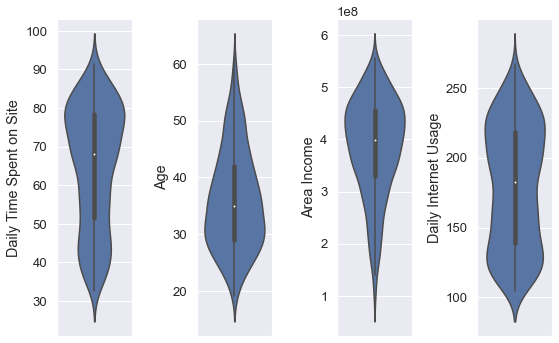

In [117]:
fitur = ['Daily Time Spent on Site','Age', 'Area Income', 'Daily Internet Usage']

for i in range(0, len(fitur)):
    plt.rcParams['figure.figsize'] = (8,5)
    plt.subplot(1,len(fitur),i+1)
    sns.violinplot(y=df[fitur[i]])
    plt.tight_layout()  

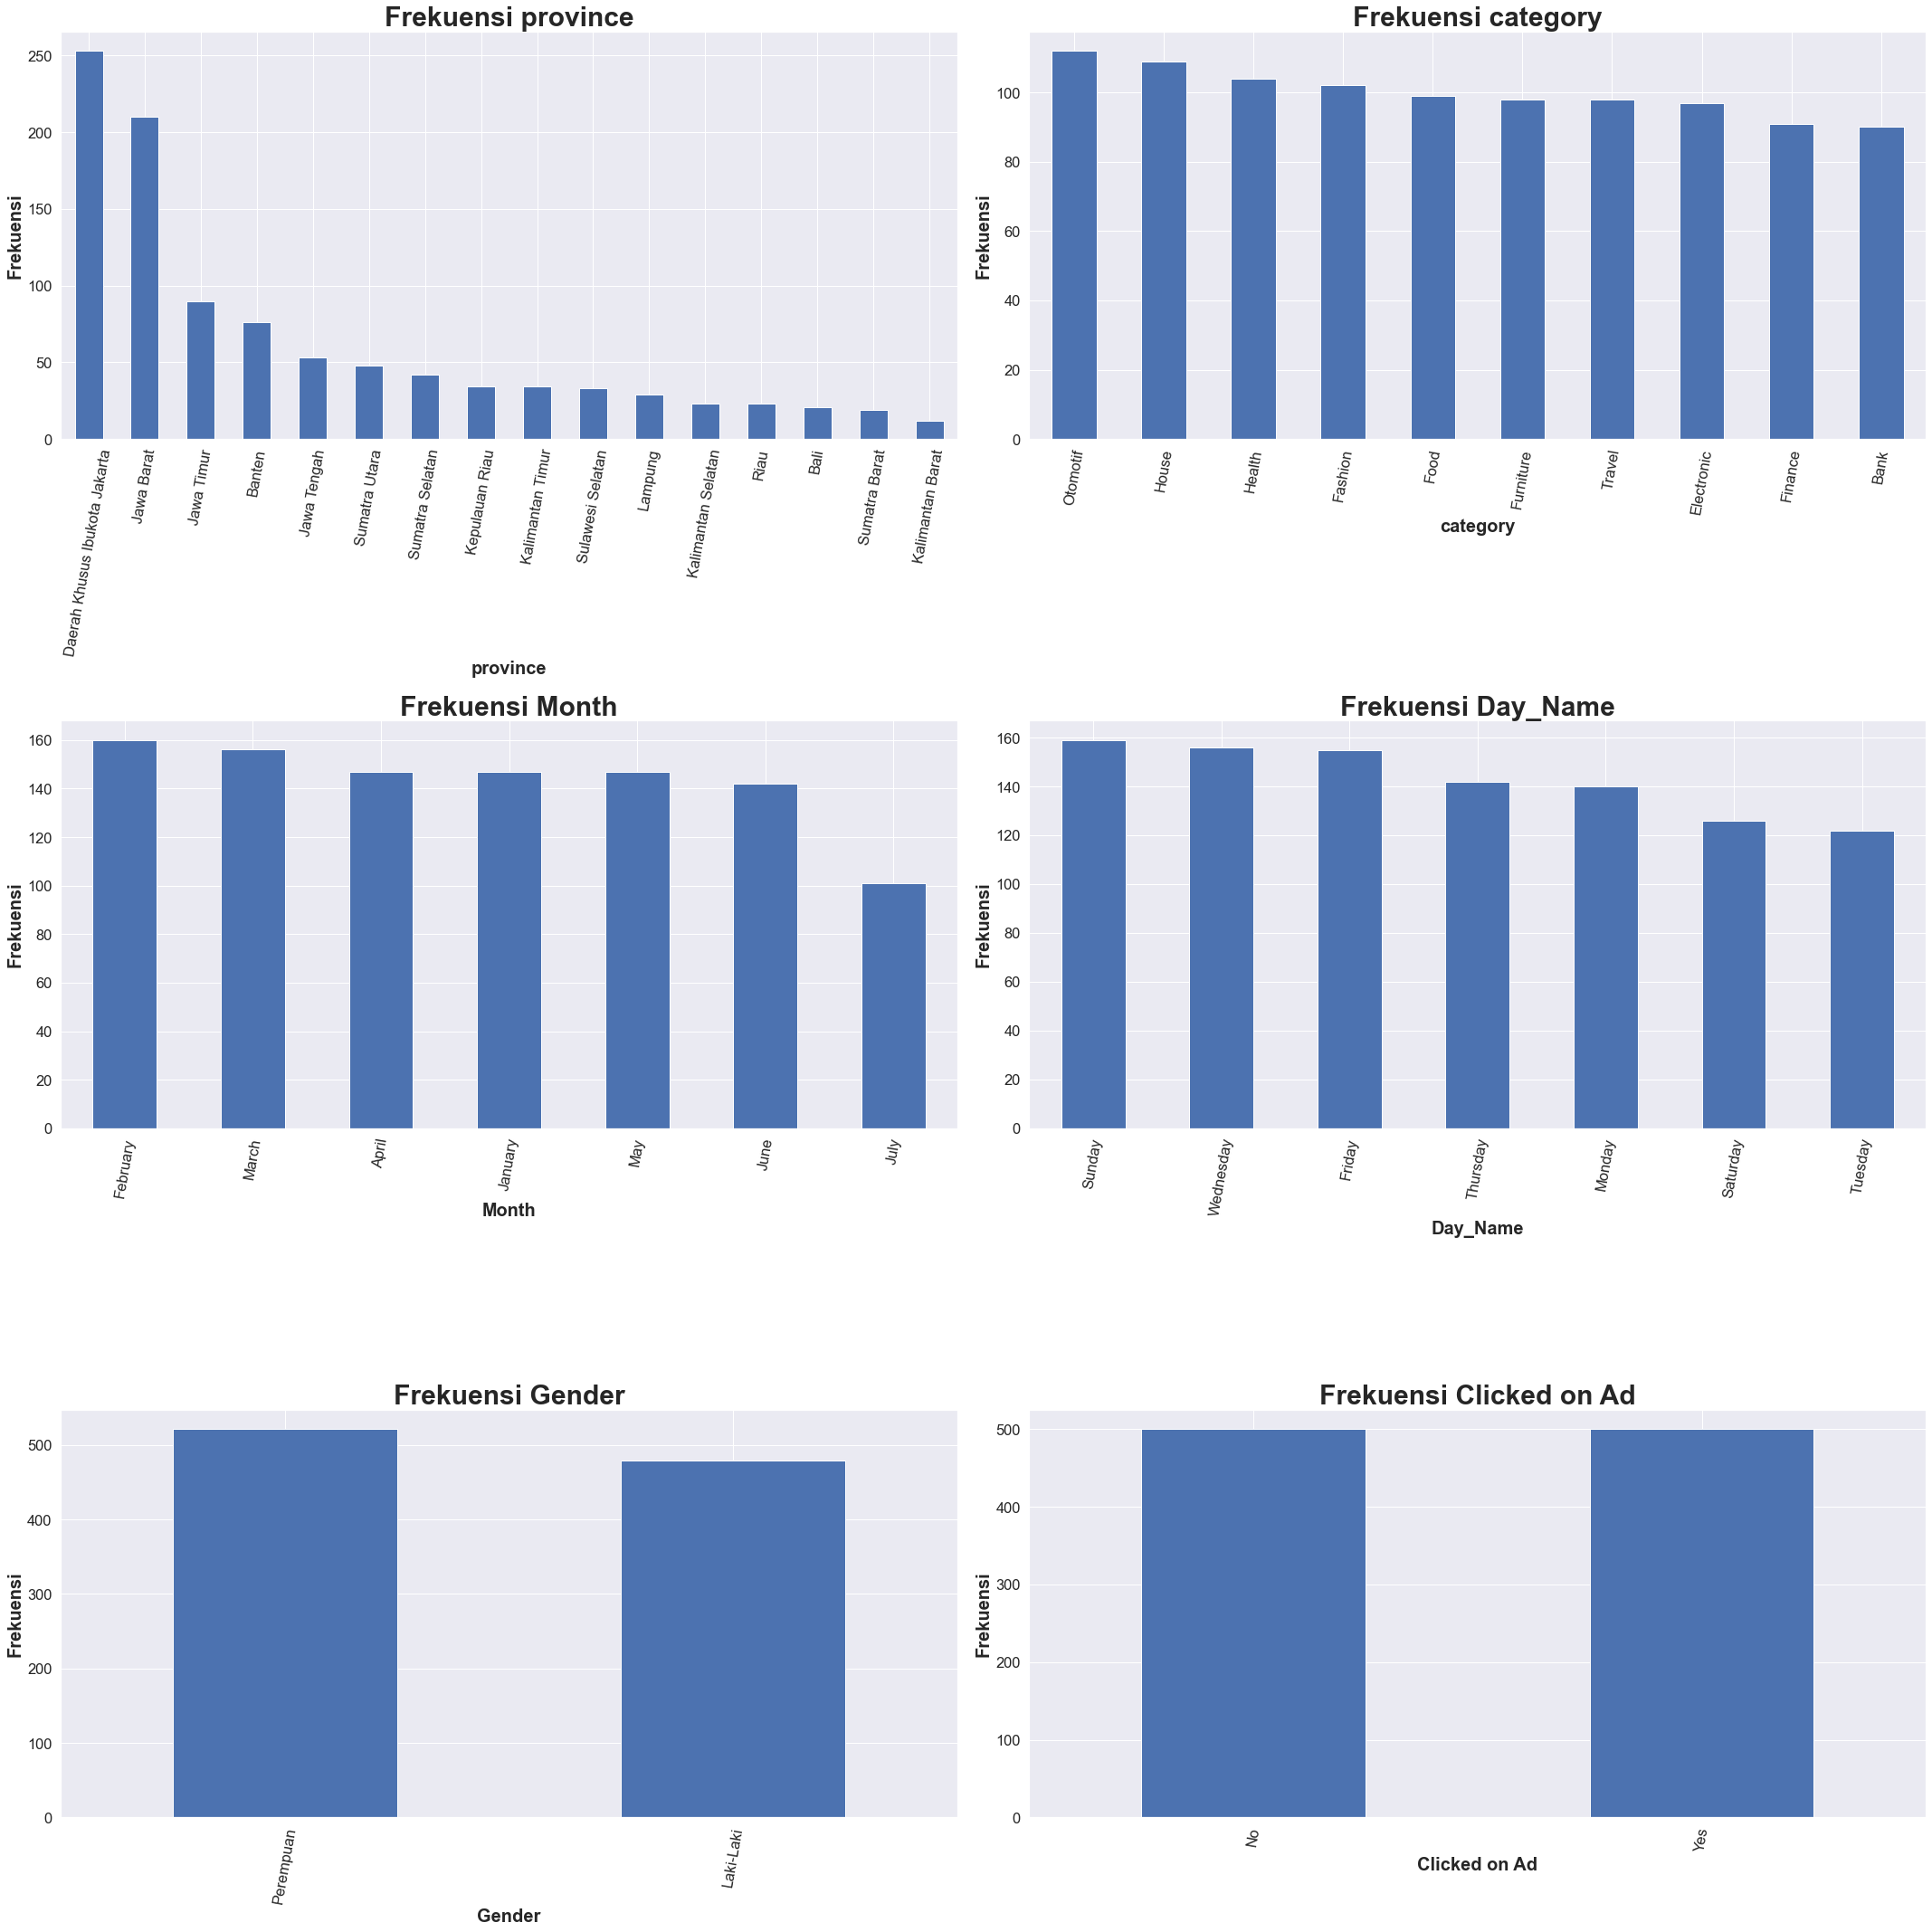

In [118]:
features = ['province', 'category', 'Month', 'Day_Name','Gender', 'Clicked on Ad']
for i in range(0, len(features)):
    plt.rcParams['figure.figsize'] = (30, 30)
    sns.set(font_scale=1.5)
    plt.subplot(3,2,i+1)
    value_counts = df[features[i]].value_counts()
    value_counts.plot(kind='bar')
    plt.title("Frekuensi "+features[i], fontsize=30, weight='bold')
    plt.xlabel(features[i], fontsize=20, weight='bold')
    plt.ylabel('Frekuensi', fontsize=20, weight='bold')
    plt.xticks(rotation = 80)
    plt.tight_layout()

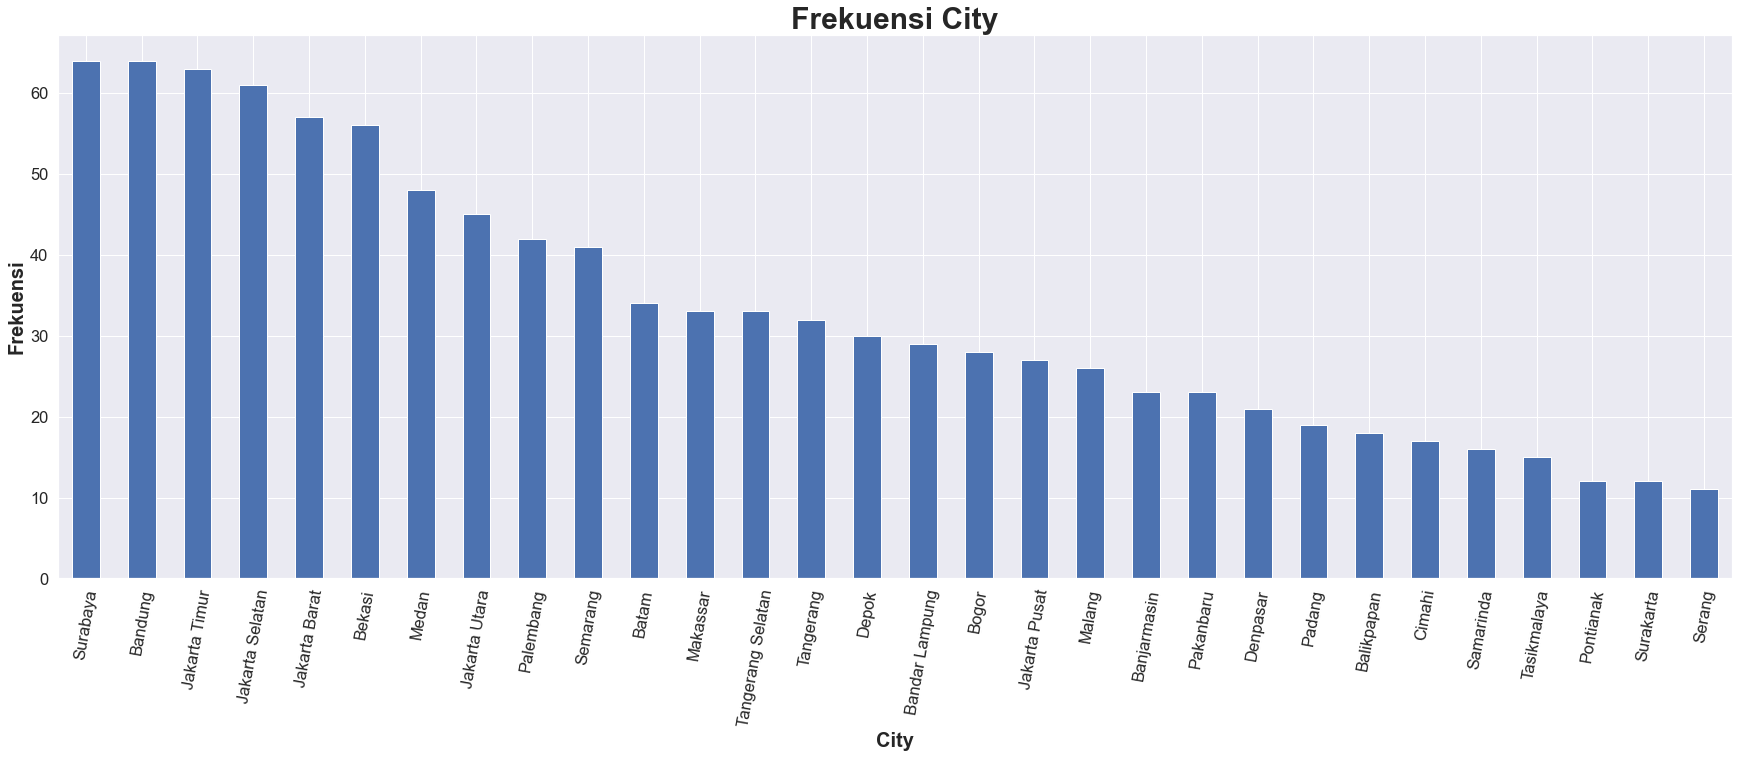

In [119]:
plt.rcParams['figure.figsize'] = (30, 10)
sns.set(font_scale=1.5)
value_counts = df['city'].value_counts().plot(kind='bar')
plt.title("Frekuensi City", fontsize=30, weight='bold')
plt.xlabel("City", fontsize=20, weight='bold')
plt.ylabel('Frekuensi', fontsize=20, weight='bold')
plt.xticks(rotation = 80)
plt.show()

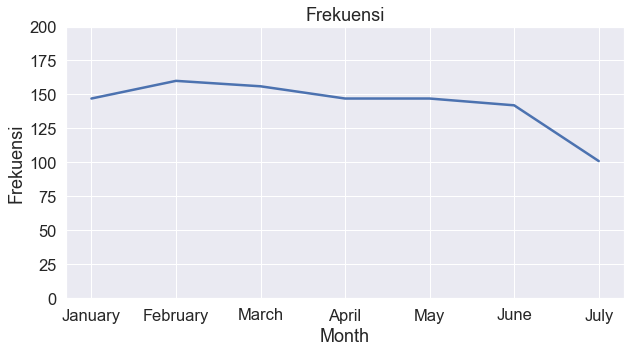

In [120]:
timestamp = df.groupby(['Month']).agg({'Gender':['count']}).reset_index()
timestamp.columns = ['Month','Frekuensi']
months = ['January','February','March','April','May','June',
         'July','August','September','October','November','December']
timestamp['Month'] = pd.Categorical(timestamp['Month'], categories=months, ordered=True)

plt.rcParams["figure.figsize"] = (10,5)
sns.lineplot(timestamp['Month'],timestamp['Frekuensi'],palette="tab10", linewidth=2.5)
plt.title('Frekuensi')
plt.ylim(0,200)
plt.show()

## Bivariate Analysis

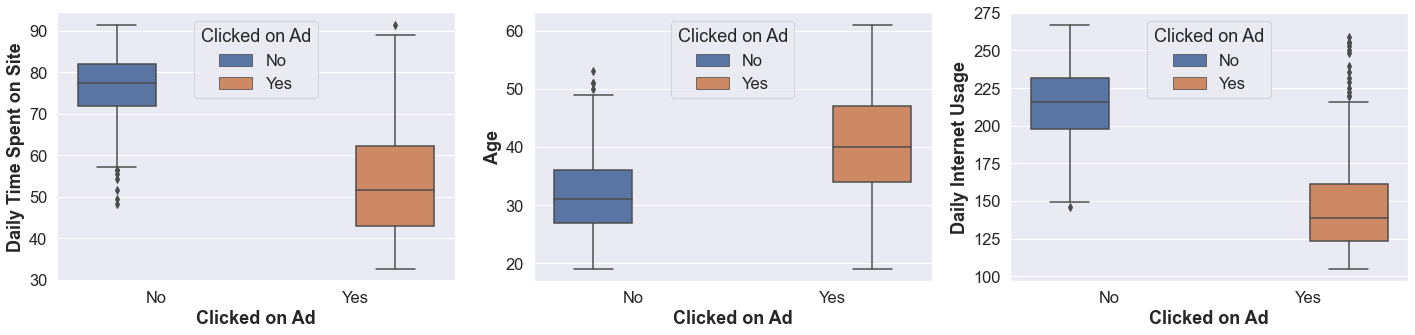

In [121]:
features = ['Daily Time Spent on Site', 'Age', 'Daily Internet Usage']
for i in range(0, len(features)):
    plt.rcParams['figure.figsize'] = (20,5)
    plt.subplot(1,3,i+1)
    sns.boxplot(y=features[i], x='Clicked on Ad',hue='Clicked on Ad', data=df)
    plt.xlabel('Clicked on Ad',weight='bold')
    plt.ylabel(features[i],weight='bold')
    plt.legend(title ='Clicked on Ad', loc = 'upper center')
    plt.tight_layout()    

- Sebagian besar customer yang menghabiskan waktunya untuk berada di internet dan melakukan clicked pada iklan adalah customer yang berusia di antara 35 - 50 tahun. Sedangkan customer yang berusia antara 27-35 tahun sebagian besar tidak melakukan klik pada iklan. 
- Semakin lama waktu yang dihabiskan untuk berada di situs, customer cenderung tidak melakukan klik pada iklan.
- Semakin tinggi penggunaan internet, cenderung untuk tidak melakukan klik pada iklan yang ada pada situs 

<Figure size 3600x1080 with 0 Axes>

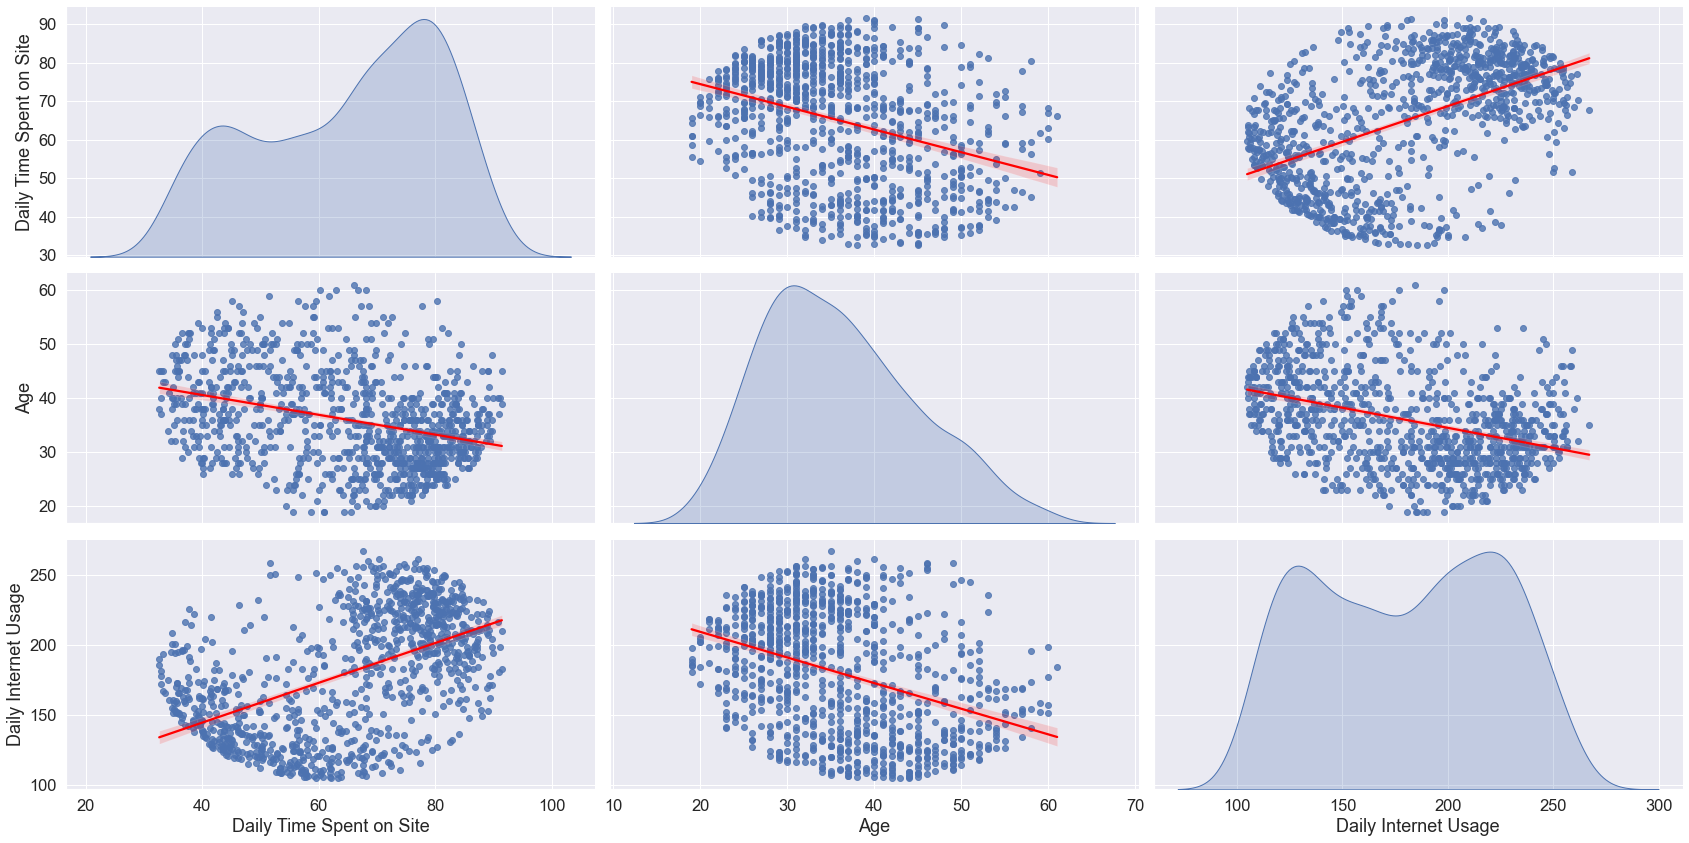

In [122]:
features = df[['Daily Time Spent on Site', 'Age', 'Daily Internet Usage']]
plt.figure(figsize=(50, 15))
sns.pairplot(features, diag_kind='kde', kind="reg",plot_kws={'line_kws':{'color':'red'}}, height=4, aspect=2) 

- Semakin tinggi usia customer penggunaan internet harian semakin sebentar 
- Semakin tinggi usia customer, waktu harian yang dihabiskan untuk berada di situe juga semakin sebentar 
- Semakin tinggi penggunaan harian internet, waktu harian yang dihabiskan untuk berada di situs juga semakin lama

In [123]:
def stackedbar(variabel):
    
    df_rate = categoric[[variabel,'Clicked on Ad']]
    df_rate

    cross_tab_prop = pd.crosstab(index=df_rate[variabel],
                                 columns=df_rate['Clicked on Ad'],
                                 normalize="index")
    cross_tab_prop = cross_tab_prop[['Yes','No']]
    cross_tab_prop = cross_tab_prop.sort_values(by='Yes', ascending=False).head(30)
    cross_tab_prop

    cross_tab_prop.plot(kind='bar', stacked=True, color=['Rosybrown','Steelblue'],figsize=(30, 8))

    plt.legend(loc="upper center",ncol=5,title='Clicked on Ad', fontsize = 15)
    sns.set(font_scale=1.5)
    plt.axhline(y = categoric['Clicked on Ad'].value_counts(True)[0], color ="red", linestyle ="--")
    plt.text(x=-0.5,y=1.42,s="Proportion customer clicked on ad based on" + ' ' + variabel,fontsize=25,weight='bold')
    plt.text(x=0.27,y=cross_tab_prop['No'].mean()-0.05,s='Proportion customer clicked on Ad overall',fontsize=14,weight='bold')
    plt.xlabel(variabel,fontsize = 20,weight='bold')
    plt.ylabel("Proportion",fontsize = 20,weight='bold')
    plt.ylim(0,1.4)
    plt.xticks(rotation = 0)
    for n, x in enumerate([*cross_tab_prop.index.values]):
        for (proportion, y_loc) in zip(cross_tab_prop.loc[x],
                                       cross_tab_prop.loc[x].cumsum()):

            plt.text(x=n - 0.15,
                     y=(y_loc - proportion)*1.06 + (proportion / 2),
                     s=f'{np.round(proportion * 100, 1)}%', 
                     color="White",
                     fontsize=15,
                     fontweight="bold")

    plt.show()

In [124]:
def stackedbar1(variabel):
    
    df_rate = categoric[[variabel,'Clicked on Ad']]
    df_rate

    cross_tab_prop = pd.crosstab(index=df_rate[variabel],
                                 columns=df_rate['Clicked on Ad'],
                                 normalize="index")
    cross_tab_prop = cross_tab_prop[['Yes','No']]
    cross_tab_prop = cross_tab_prop.sort_values(by='Yes', ascending=False).head(30)
    cross_tab_prop


    cross_tab_prop.plot(kind='bar', stacked=True, color=['Rosybrown','Steelblue'],figsize=(30, 8))

    plt.legend(loc="upper center",ncol=5,title='Clicked on Ad', fontsize = 15)
    sns.set(font_scale=1.5)
    sns.set_style('darkgrid')
    plt.axhline(y = categoric['Clicked on Ad'].value_counts(True)[0], color ="red", linestyle ="--")
    plt.text(x=-0.5,y=1.42,s="Proportion customer clicked on ad based on" + ' ' + variabel,fontsize=25,weight='bold')
    plt.text(x=0.27,y=cross_tab_prop['No'].mean()-0.05,s='Proportion customer clicked on Ad overall',fontsize=14,weight='bold')
    plt.xlabel(variabel,fontsize = 20,weight='bold', y=-0.2)
    plt.ylabel("Proportion",fontsize = 20,weight='bold')
    plt.ylim(0,1.4)
    plt.xticks(rotation = 70)
    plt.show()

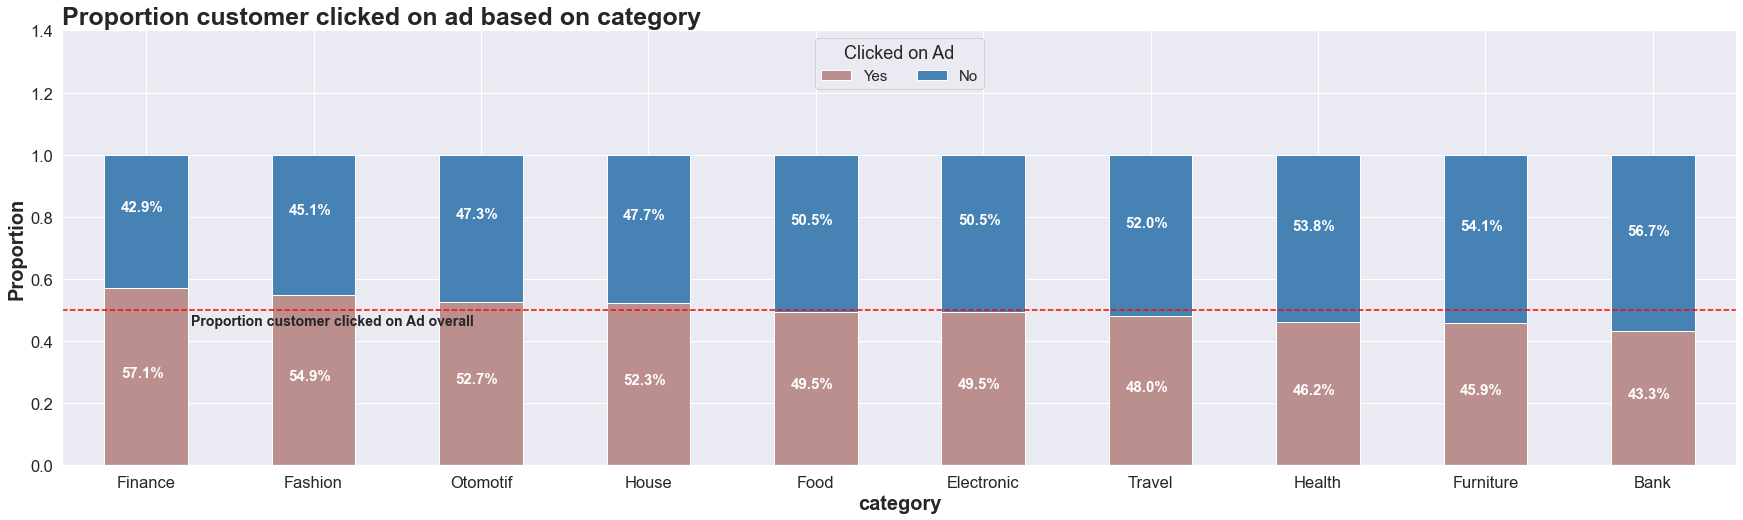

In [125]:
stackedbar('category')

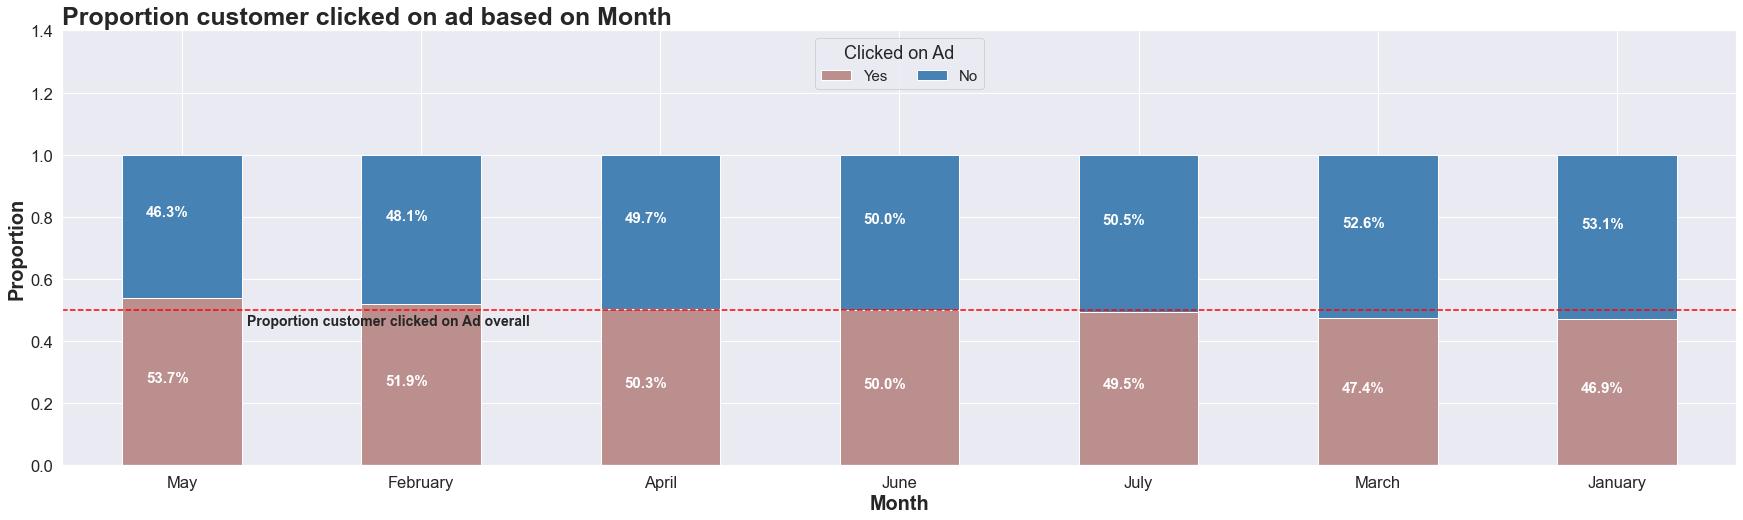

In [126]:
stackedbar('Month')

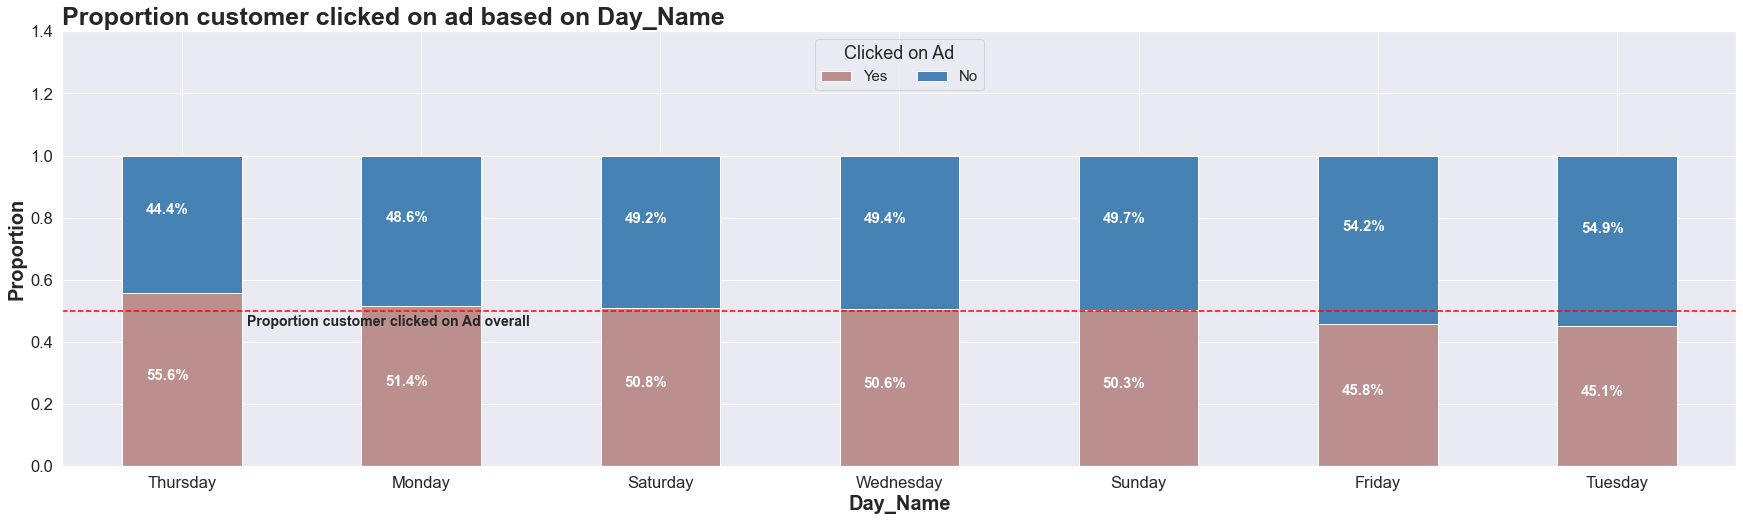

In [127]:
stackedbar('Day_Name')

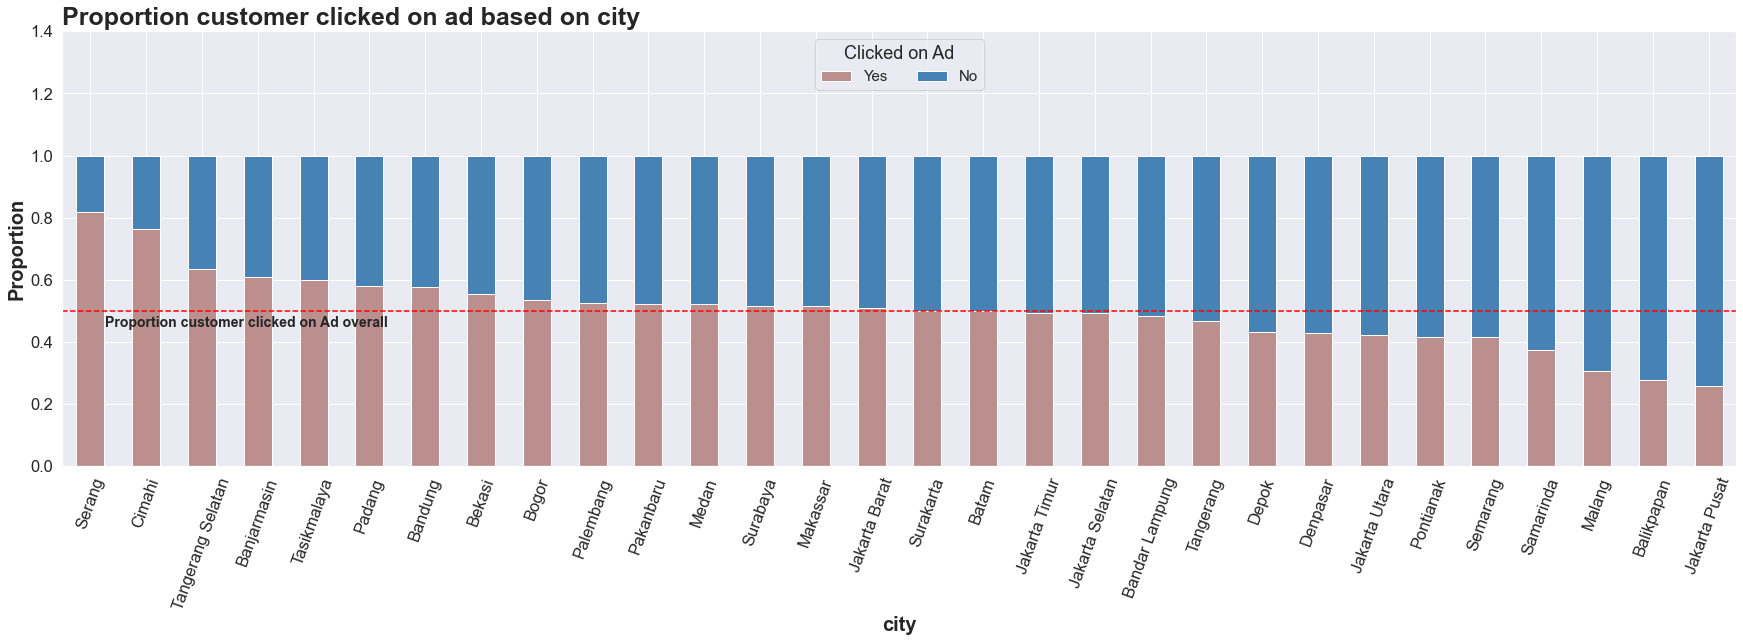

In [128]:
stackedbar1('city')

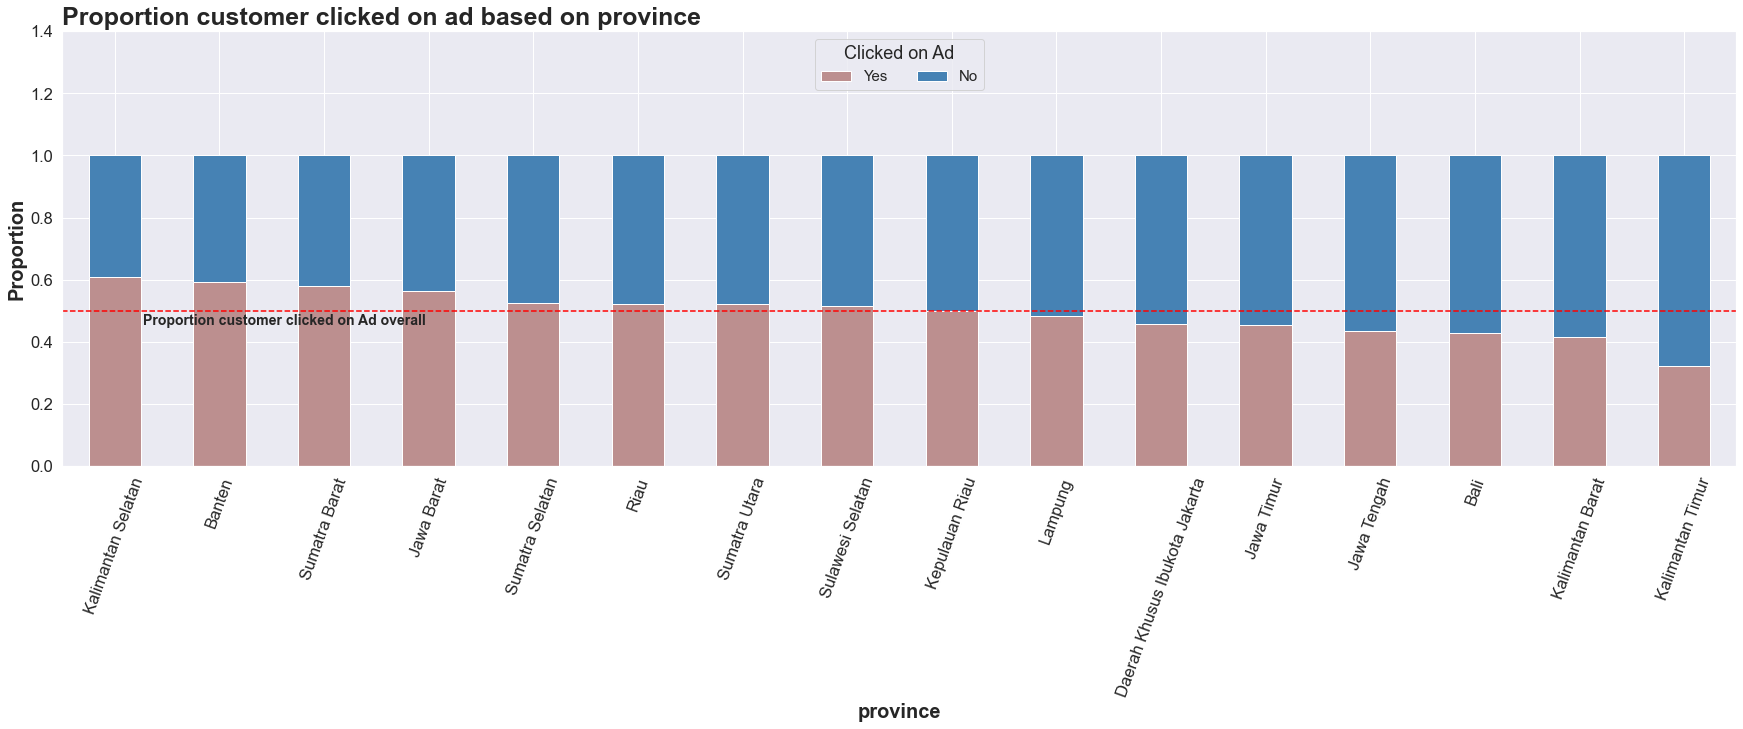

In [129]:
stackedbar1('province')

### Multivariate Analysis

(20.0, 120.0)

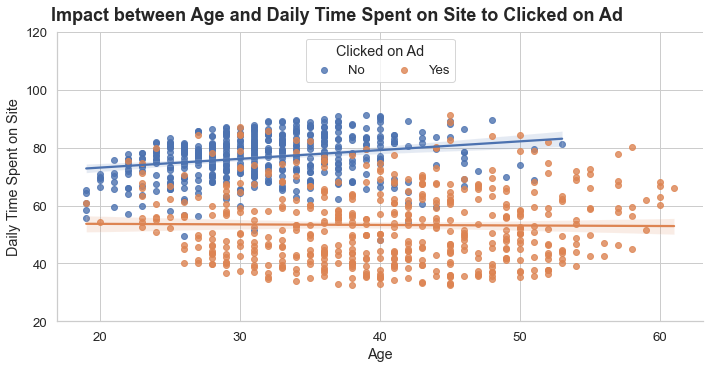

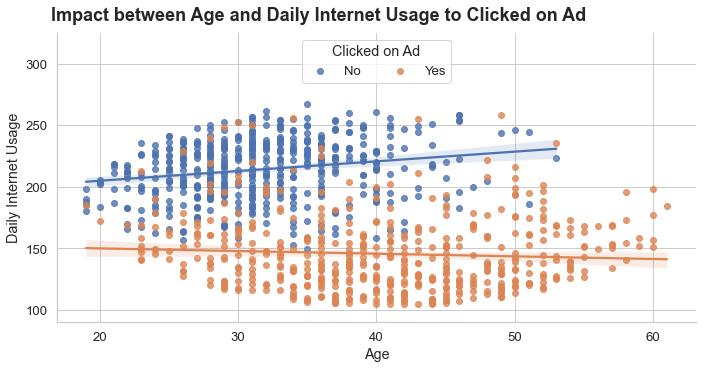

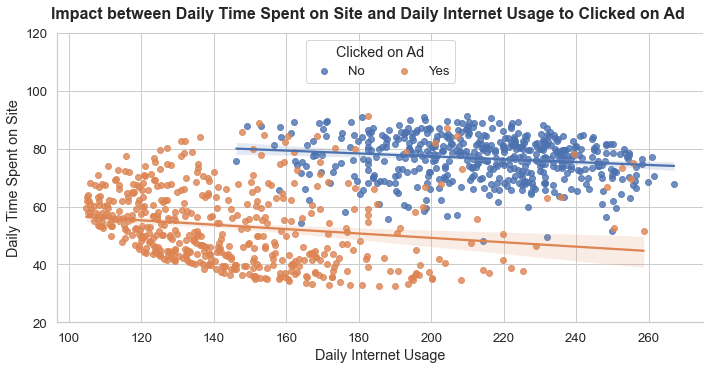

In [130]:
dataset = df[['Daily Time Spent on Site', 'Age',  'Daily Internet Usage','Clicked on Ad']]
sns.set(font_scale=1.2)
sns.set_style('whitegrid')
sns.lmplot(x ='Age', y ='Daily Time Spent on Site', data = dataset, 
           hue ='Clicked on Ad', markers =['o', 'o'],height=5, aspect=2, legend=False)
plt.text(x=16.5, y=124, s='Impact between Age and Daily Time Spent on Site to Clicked on Ad', fontsize=18, weight='bold')
plt.legend(title ='Clicked on Ad', loc = 'upper center', ncol = 2)
plt.ylim(20,120)

sns.lmplot(x ='Age', y ='Daily Internet Usage', data = dataset, 
           hue ='Clicked on Ad', markers =['o', 'o'],height=5, aspect=2, legend=False)
plt.text(x=16.5, y=335, s='Impact between Age and Daily Internet Usage to Clicked on Ad', fontsize=18, weight='bold')
plt.legend(title ='Clicked on Ad', loc = 'upper center', ncol = 2)
plt.ylim(90,325)

sns.lmplot(x ='Daily Internet Usage', y ='Daily Time Spent on Site', data = dataset, 
           hue ='Clicked on Ad', markers =['o', 'o'],height=5, aspect=2, legend=False)
plt.text(x=95, y=125, s='Impact between Daily Time Spent on Site and Daily Internet Usage to Clicked on Ad', fontsize=16, weight='bold')
plt.legend(title ='Clicked on Ad', loc = 'upper center', ncol = 2)
plt.ylim(20,120)

- Customer yang berusia sekitar 25-55 tahun dan yang menghabiskan waktu dari 30-70 menit per hari berada di internet merupakan customer yang melakukan clicked pada ad. Sedangkan pada customeryang berusia 20-40 tahun dan menghabiskan waku 70-90 menit per hari untuk berada di internet merupakan customer yang tidak melakukan clicked pada Ad. Dapat dilihat bahwa, semakin tinggi usia customer dan semakin sebentar untuk menghabiskan waktu berada di internet, cenderung melakukan clicked pad Ad. Sedangkan semakin tinggi usia customer dan semakin lama daily time spent on site, cenderung untuk tidak melakukan on Site. 

- Semakin tinggi usia customer dan penggunaan internet harian semakin sedikit, customer cenderung untuk melakukan clicked pada Ad. Sedangkan semakin tinggi usia customer dan semakin banyak penggunaan internet harian, cenderung untuk tidak melakukan clicked pada Ad

- Sebagian besar customer pengguna internet harian antara 110 - 170 dan menghabiskan waktu di website selama 30-70 menit per hari merupakan customer yang melakukan click pada Ad. Sedangkan sebagian besar customer yang pengguna internet harian antara 180 -260 dan menghabiskan waktu antara 60-90 menit per hari berada di website merupakan customer yang tidak melakukan clicked pada Ad

### Heatmap Correlation

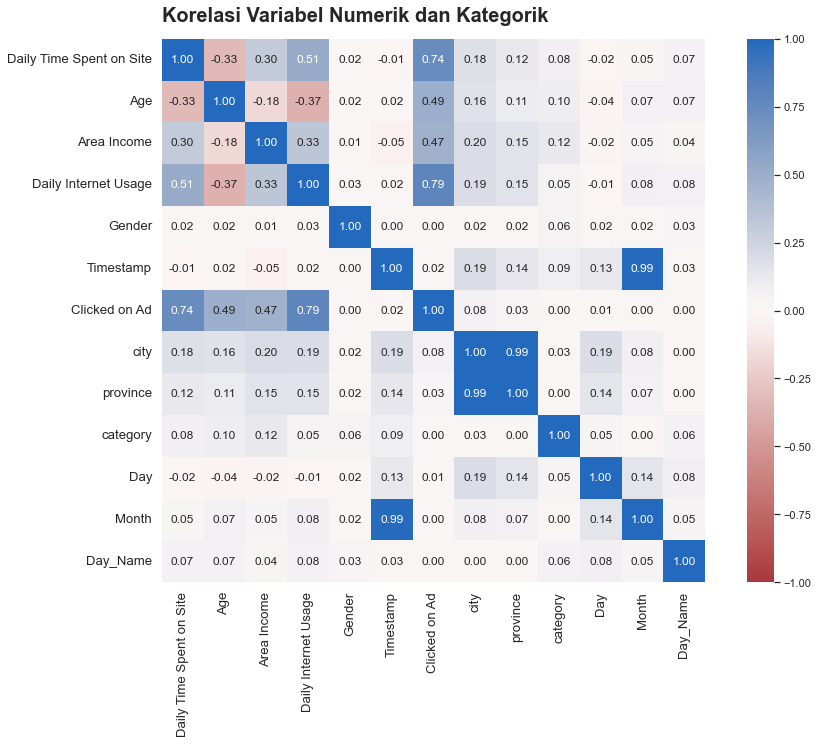

In [131]:
from dython.nominal import associations
fig, ax = plt.subplots(figsize =(15,10))
sns.set(font_scale=1)
plt.text(x=0,y=-0.4,s="Korelasi Variabel Numerik dan Kategorik",fontsize=20,weight='bold')
# Estimate and generate Cramer's V association plot
cramers_v = associations(df, nom_nom_assoc = 'cramer',cmap = "vlag_r", ax=ax)
plt.show()

- Ada beberapa variabel yang redundant antara lain : Month dengan Timestamp dan City dengan Province
- Variabel redundant yang memiliki korelasi paling lemah dengan variabel target akan didrop seperti variabel Month dan Province
- Variabel **age dan income memiliki korelasi positive yang sedang dengan Clicked on Ad**
- Variabel **daily time spent on site dan daily internet usage memiliki korelasi positive yang kuat dengan Clicked on Ad**
- Variabel daily time spent on site dan daily internet usage dengan age memiliki korelasi negative sedang 
- Variabel daily time spent on site dan area income, memiliki korelasi positive sedang dengan variabel daily internet usage 
- Variabel daily time spent on site dengan area income memiliki korelasi positive sedang

In [132]:
df = df.drop(['Month','province'], axis=1)

### Uji statistik

In [133]:
yes_clicked = df[df["Clicked on Ad"]=='Yes']
no_clicked = df[df["Clicked on Ad"]=='No']
list=[]
list_kolom = []
fitur = numeric.columns
for i in fitur:
    stat, p= st.f_oneway(yes_clicked[i], no_clicked[i])
    list.append(p)
list
print('Hasil Uji Statistik ANOVA :')
for i in range(0,len(fitur)):
    if list[i] > 0.05:
        result =  "Terima H0"
        print(result,fitur[i],'p-value',list[i])
        kolom = fitur[i]
        list_kolom.append(kolom)
    else:
        result =  "Terima H1"
        print(result,fitur[i],'p-value',list[i])
print("")
print('Kolom numerik yang akan didrop berdasarkan uji statistik')
print(list_kolom)

Hasil Uji Statistik ANOVA :
Terima H1 Daily Time Spent on Site p-value 1.4930331411686328e-175
Terima H1 Age p-value 3.1298083092905155e-62
Terima H1 Area Income p-value 2.248973881598795e-57
Terima H1 Daily Internet Usage p-value 3.2356732468665635e-210
Terima H0 Day p-value 0.8678227400097878

Kolom numerik yang akan didrop berdasarkan uji statistik
['Day']


- Variabel Day tidak berpengaruh terhadap variabel target Clicked on Ad sedemikian sehingga akan didrop

In [134]:
df = df.drop(['Day'], axis=1)

- Telah dilakukan feature engineering/extraction terhadap variabel Timestamp sedemikian sehingga akan didrop

In [135]:
df = df.drop(['Timestamp'], axis=1)

In [136]:
df.shape

(1000, 9)

# Data Preprocessing

## Handling Outlier

In [137]:
numeric.columns

Index(['Daily Time Spent on Site', 'Age', 'Area Income',
       'Daily Internet Usage', 'Day'],
      dtype='object')

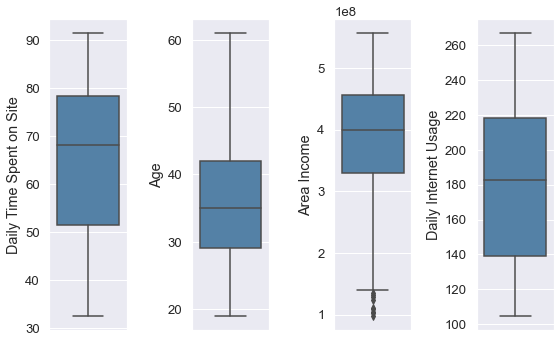

In [138]:
features = numeric.columns.tolist()
features.remove('Day')

for i in range(0, len(features)):
    plt.rcParams['figure.figsize'] = (10,5)
    sns.set(font_scale=1.2)
    plt.subplot(1,5,i+1)
    sns.boxplot(y=df[features[i]], color='Steelblue')
    plt.ylabel(features[i])
    plt.xticks(rotation = 45)
    plt.tight_layout()

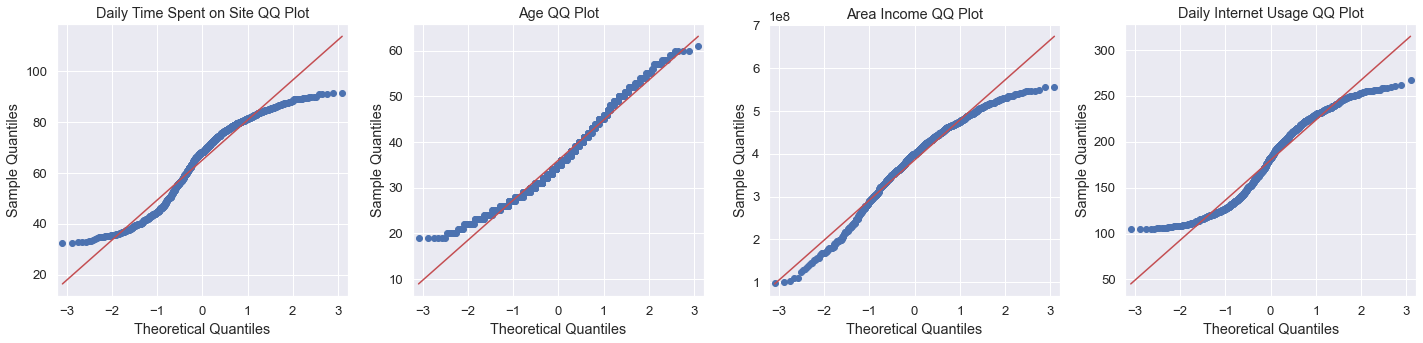

In [139]:
import statsmodels.api as sm
features = numeric.columns.tolist()
features.remove('Day')

fig, axes = plt.subplots(ncols=4, nrows=1, sharex=True, figsize=(20, 5))
for i, ax in zip(features, np.ravel(axes)):
    sm.qqplot(df[i], line='s', ax=ax)
    ax.set_title(f'{i} QQ Plot')
    plt.tight_layout()

- Tidak ada outlier bertipe global pada variabel numerik

## Feature Encoding

Strategi feature encoding 
- Day_Name dan Gender akan diencoding menggunakan Label Encoding
- City dan Category akan diencoding menggunakan one hot encoding 
- Variabel numerik akan diencoding menggunakan standard scaler

In [140]:
ord_cols = ['Day_Name', 'Gender']
ohe_cols = ['city', 'category']
num_cols = ['Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage']

In [141]:
df['Clicked on Ad'] = np.where(df['Clicked on Ad']=='Yes',1,0)

In [142]:
X = df[num_cols+ord_cols+ohe_cols]
y = df['Clicked on Ad']


In [143]:
from sklearn.model_selection import train_test_split

# X = X[num_cols+ord_cols+ohe_cols]
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,test_size=0.2, random_state=42)

In [144]:
#Ordinal Encoder
ordinal_encoder = OrdinalEncoder(categories = [['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                                               ["Laki-Laki","Perempuan"]])
ord_pipe = Pipeline([('ordinal_encoder', ordinal_encoder)])

#Numeric 
scaler = StandardScaler()
num_pipe = Pipeline([
    ('scaler', scaler)])

#Onehot
onehot = OneHotEncoder()
ohe_pipe = Pipeline([('onehot_encoder', onehot)])

In [145]:
from sklearn.preprocessing import FunctionTransformer

In [146]:
preprocessor = ColumnTransformer(
    [
     ('num_pipe', num_pipe, num_cols),
     ('ord_pipe', ord_pipe, ord_cols),
     ('ohe_pipe', ohe_pipe, ohe_cols)
     ]
    )

In [147]:
preprocessor

ColumnTransformer(transformers=[('num_pipe',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['Daily Time Spent on Site', 'Age',
                                  'Area Income', 'Daily Internet Usage']),
                                ('ord_pipe',
                                 Pipeline(steps=[('ordinal_encoder',
                                                  OrdinalEncoder(categories=[['Monday',
                                                                              'Tuesday',
                                                                              'Wednesday',
                                                                              'Thursday',
                                                                              'Friday',
                                                                              'Saturday',
                                                                              'Sunday'],
                                                                             ['Laki-Laki',
                                                                              'Perempuan']]))]),
                                 ['Day_Name', 'Gender']),
                                ('ohe_pipe',
                                 Pipeline(steps=[('onehot_encoder',
                                                  OneHotEncoder())]),
                                 ['city', 'category'])])

In [148]:
X_train.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Day_Name,Gender,city,category
747,49.13,32,287680190.0,120.49,Friday,Perempuan,Bekasi,Finance
586,78.29,38,404914720.0,252.07,Tuesday,Perempuan,Jakarta Utara,Furniture
519,35.00,40,322236110.0,151.25,Saturday,Laki-Laki,Tangerang,Health
770,71.14,30,488308170.0,224.82,Tuesday,Perempuan,Depok,House
600,84.00,48,328079710.0,136.21,Sunday,Laki-Laki,Tangerang,House


In [149]:
X_train_encoding = preprocessor.fit_transform(X_train)
X_test_encoding = preprocessor.transform(X_test)

In [150]:
all_columns = num_cols + ord_cols + pd.get_dummies(X_train[ohe_cols]).columns.tolist()

In [151]:
X_train = X_train_encoding.toarray()
X_train_encoding = pd.DataFrame(X_train, columns= all_columns)

In [152]:
X_test = X_test_encoding.toarray()

# Modeling

In [153]:
#modelling with scoring metrics
def cross_validation(model):
    model_name = []
    cv_accuracy_mean = []
    cv_accuracy_std = []
    training_accuracy = []
    
    cv_recall_mean = []
    cv_recall_std = []
    training_recall = []
    
    cv_precision_mean = []
    cv_precision_std = []
    training_precision = []
    
    cv_f1_mean = []
    cv_f1_std = []
    training_f1 = []
    
    cv_roc_auc_mean = []
    cv_roc_auc_std = []
    training_roc_auc = []

    
    for name, model in models:
        model_name.append(name)

        #scoring
        scoring= ['accuracy','recall', 'precision', 'f1', 'roc_auc']
        
        #cross_validate 
        cv_score = cross_validate(model, X_train, y_train, scoring=scoring, cv=5, n_jobs = -1)
        
        # training
        model.fit(X_train, y_train)
        y_pred = model.predict(X_train)

        training_accuracy.append(accuracy_score(y_train,y_pred))
        training_recall.append(recall_score(y_train,y_pred))
        training_precision.append(precision_score(y_train, y_pred))
        training_f1.append(f1_score(y_train, y_pred))
        training_roc_auc.append(roc_auc_score(y_train, y_pred))
        
        #tes
        cv_accuracy_mean.append(abs(cv_score['test_accuracy']).mean())
        cv_accuracy_std.append(abs(cv_score['test_accuracy']).std())
        cv_recall_mean.append(abs(cv_score['test_recall']).mean())
        cv_recall_std.append(abs(cv_score['test_recall']).std())
        cv_precision_mean.append(abs(cv_score['test_precision']).mean())
        cv_precision_std.append(abs(cv_score['test_precision']).std())
        cv_f1_mean.append(abs(cv_score['test_f1']).mean())
        cv_f1_std.append(abs(cv_score['test_f1']).std())
        cv_roc_auc_mean.append(abs(cv_score['test_roc_auc']).mean())
        cv_roc_auc_std.append(abs(cv_score['test_roc_auc']).std())
   
    return pd.DataFrame({
        'Model': model_name,
        'Training Accuracy' : training_accuracy,
        'CV Accuracy (mean)' : cv_accuracy_mean,
        'CV Accuracy (std)' : cv_accuracy_std,
        'Training Recall' : training_recall,
        'CV Recall (mean)': cv_recall_mean,
        'CV Recall (std)': cv_recall_std,
        'Training Precision' : training_precision,
        'CV Precision (mean)' : cv_precision_mean,
        'CV Precision (std)' : cv_precision_std,
        'Training F1' : training_f1,
        'CV F1 (mean)' : cv_f1_mean,
        'CV F1 (std)' : cv_f1_std,
        'Training AUC_ROC' : training_roc_auc,
        'CV AUC_ROC (mean)' : cv_roc_auc_mean,
        'CV AUC_ROC (std)' : cv_roc_auc_std,
    })

In [154]:
#assign model ke dalam variabel
models = [
    ['Logistic Regression', LogisticRegression(class_weight='balanced', random_state=42)],
    ['XGB', XGBClassifier(verbosity=0)],
    ['Decision Tree', DecisionTreeClassifier(class_weight='balanced', random_state=42)],
    ['Random Forest', RandomForestClassifier(class_weight='balanced', random_state=42)],
    ['Naive Bayes', GaussianNB()],
    ['LGBM', LGBMClassifier(class_weight='balanced', random_state=42, n_jobs=-1)]
]

In [155]:
%%time
cv_result = cross_validation(models)
cv_result

CPU times: total: 797 ms
Wall time: 3.15 s


,Model,Training Accuracy,CV Accuracy (mean),CV Accuracy (std),Training Recall,CV Recall (mean),CV Recall (std),Training Precision,CV Precision (mean),CV Precision (std),Training F1,CV F1 (mean),CV F1 (std),Training AUC_ROC,CV AUC_ROC (mean),CV AUC_ROC (std)
0,Logistic Regression,0.97125,0.96625,0.011592,0.9625,0.9600,0.020000,0.979644,0.972378,0.014108,0.970996,0.965984,0.011937,0.97125,0.991844,0.002150
1,XGB,1.00000,0.95125,0.013346,1.0000,0.9475,0.020000,1.000000,0.954897,0.015996,1.000000,0.951028,0.013604,1.00000,0.990531,0.003037
2,Decision Tree,1.00000,0.93500,0.005000,1.0000,0.9350,0.031024,1.000000,0.936565,0.026787,1.000000,0.934907,0.005811,1.00000,0.935000,0.005000
3,Random Forest,1.00000,0.95750,0.012748,1.0000,0.9550,0.028062,1.000000,0.960143,0.013539,1.000000,0.957229,0.013501,1.00000,0.990250,0.005484
4,Naive Bayes,0.90000,0.84250,0.027214,0.9175,0.8500,0.079057,0.886473,0.842514,0.045866,0.901720,0.842225,0.033337,0.90000,0.882906,0.017691
5,LGBM,1.00000,0.95625,0.005590,1.0000,0.9500,0.019365,1.000000,0.962597,0.016782,1.000000,0.955943,0.005847,1.00000,0.990375,0.004859
